# Import Packages

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

# Load Data

In [ ]:
def load_directory(path):
    df = []
    lowercase_chars = 'abcdefghijklmnopqrstuvwxyz'
    uppercase_chars = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    
    if not os.path.exists(path):
        print(f"Error: Directory not found: {path}")
        return pd.DataFrame()
    
    dir_list = os.listdir(path)
    
    for child in dir_list:
        child_path = os.path.join(path, child)
        child_name = child.split('_')[0]
        
        if not child_name in lowercase_chars:
            continue
        
        for img_path in os.listdir(child_path):
            direct = os.path.join(child_path, img_path)
            df.append([direct, child_name])
        
    df = pd.DataFrame(df, columns=['image', 'label'])
    print("The number of samples found: ", len(df))
    
    return df.copy()

# Driver code
dataset_path = 'data/raw/character_set3/training_data/'

df = load_directory(dataset_path)
df.head()

The number of samples found:  85199


,image,label
0,data/raw/character_set3/training_data/a_L\A_L_...,a
1,data/raw/character_set3/training_data/a_L\A_L_...,a
2,data/raw/character_set3/training_data/a_L\A_L_...,a
3,data/raw/character_set3/training_data/a_L\A_L_...,a
4,data/raw/character_set3/training_data/a_L\A_L_...,a


In [ ]:
sorted_by_char = df['label'].value_counts().sort_index()
print(sorted_by_char)

label
a    3281
b    3274
c    3274
d    3277
e    3284
f    3275
g    3275
h    3275
i    3277
j    3274
k    3276
l    3276
m    3281
n    3281
o    3275
p    3275
q    3279
r    3284
s    3276
t    3276
u    3278
v    3274
w    3275
x    3276
y    3276
z    3275
Name: count, dtype: int64


# Split Data

## Split data for Training and Testing

In [ ]:
x, y = df['image'], df['label']
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.30, random_state=41)
training_df = pd.concat((X_train, Y_train), axis=1)
testing_df = pd.concat((X_test, Y_test), axis=1)

## Split data for Training and Validation

In [ ]:
x, y = training_df['image'], training_df['label']
X_train, X_valid, Y_train, Y_valid = train_test_split(x, y, test_size=0.25, random_state=41)
training_df = pd.concat((X_train, Y_train), axis=1)
validation_df = pd.concat((X_valid, Y_valid), axis=1)

# Hyperparameters

In [ ]:
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 20

# Create Generators

In [ ]:
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE, target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,  target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [ ]:
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

In [ ]:
def show_image(img, label=None) -> None:
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()

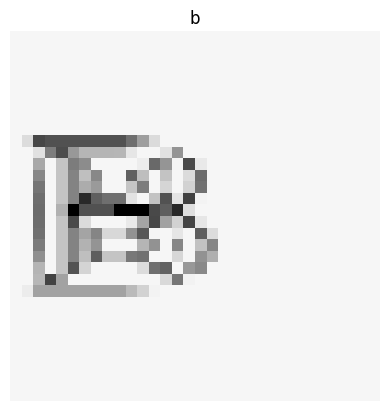

The shape of the image: (32, 32, 3)


In [ ]:
BATCH_NUM = 10
IMG_NUM = 2
show_image(train_gen[BATCH_NUM][0][IMG_NUM], mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:', train_gen[BATCH_NUM][0][IMG_NUM].shape)

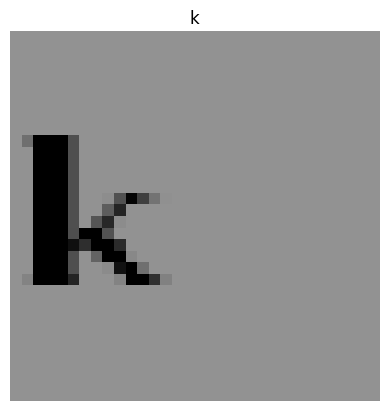

The shape of the image: (32, 32, 3)


In [ ]:
BATCH_NUM = 65
IMG_NUM = 30
show_image(train_gen[BATCH_NUM][0][IMG_NUM], mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:', train_gen[BATCH_NUM][0][IMG_NUM].shape)

# Create CNN Model

In [ ]:
model = Sequential([
    Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'),
    Conv2D(3, (3,3), strides=1, activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D((3,3)),
    Conv2D(256, (3,3), activation='relu'),
    Dropout(0.2),
    Conv2D(256, (3,3), strides=2, activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Dropout(0.2),
    Conv2D(1024, (2,2), activation='relu', padding='same'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(1024, activation='selu'),
    Dense(len(mapping), activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (32, 32, 32, 3)        │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 30, 30, 128)      │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 10, 10, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 8, 8, 256)        │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 8, 8, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 4, 4, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 2, 2, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 2, 2, 512)        │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 2, 2, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 2, 2, 1024)       │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 1, 1, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1024)             │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 26)               │        26,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,243,502 (20.00 MB)

 Trainable params: 5,243,502 (20.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
def clbck(model_name):
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.keras',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [ ]:
history = model.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck("CustomCnn"))

Epoch 1/20


c:\Users\KISEKI\anaconda3\envs\tensor_flow\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.2805 - loss: 2.6342
Epoch 1: val_loss improved from inf to 0.96514, saving model to CustomCnn_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 278s 196ms/step - accuracy: 0.2806 - loss: 2.6338 - val_accuracy: 0.7470 - val_loss: 0.9651 - learning_rate: 1.0000e-05
Epoch 2/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7130 - loss: 1.2322
Epoch 2: val_loss improved from 0.96514 to 0.68092, saving model to CustomCnn_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 253s 181ms/step - accuracy: 0.7130 - loss: 1.2321 - val_accuracy: 0.8296 - val_loss: 0.6809 - learning_rate: 1.0000e-05
Epoch 3/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7969 - loss: 0.9121
Epoch 3: val_loss improved from 0.68092 to 0.56672, saving model to CustomCnn_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 247s 176ms/step - accuracy: 0.7969 - loss: 0.9121 - val_accuracy: 0.8634 - val_loss: 0.5667 - learning_rate: 1.0000e-05
Epoch 4/20
1398/1398 ━

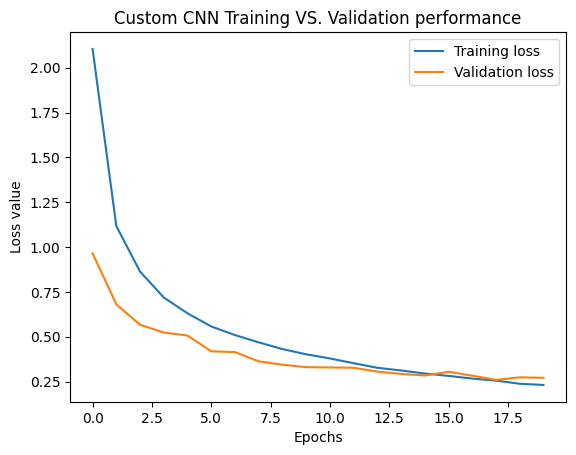

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training VS. Validation performance")
plt.show()

In [ ]:
prediction = model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x], test_gen.classes))

799/799 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step


In [ ]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

           a       0.91      0.92      0.92      1010
           b       0.90      0.97      0.93       970
           c       0.89      0.94      0.91       980
           d       0.96      0.96      0.96      1014
           e       0.96      0.90      0.93       975
           f       0.94      0.95      0.94       972
           g       0.95      0.92      0.93       987
           h       0.95      0.93      0.94      1010
           i       0.97      0.91      0.94      1002
           j       0.94      0.96      0.95       981
           k       0.92      0.96      0.94       930
           l       0.92      0.92      0.92      1004
           m       0.96      0.96      0.96      1000
           n       0.92      0.95      0.93       964
           o       0.93      0.95      0.94       952
           p       0.92      0.95      0.94      1045
           q       0.96      0.92      0.

# Load Model

In [ ]:
def load_model():
    model_path = 'CustomCnn_model.keras'
    model = tf.keras.models.load_model(model_path)
    return model

In [ ]:
def visualize_regions(image, regions):
    debug_image = image.copy()
    for (x, y, w, h) in regions:
        cv2.rectangle(debug_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.imshow("Detected Text Regions", debug_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []
    
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each contour
        rects.append([x,y,w,h])
        
    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
        
    visualize_regions(image, rects)
    
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters
    
    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image 
    del _, bin_img, full_dil_img                          # for better memory usage
    
    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]
        
        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word
        
        del _, bin_img, dil_img
        
        for char in char_parts:    
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]
            
            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indices
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)
            
            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list
            
            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space
        
    del model
    show_image(image)
    return ''.join(chars[:-1])

In [ ]:
def sort_bounding_boxes(regions):
    # Sort by `y` first (top-to-bottom) with a threshold to group by rows
    row_threshold = 20  # Adjust based on character spacing
    regions = sorted(regions, key=lambda box: box[1])

    # Group bounding boxes into rows
    rows = []
    current_row = [regions[0]]
    
    for i in range(1, len(regions)):
        if abs(regions[i][1] - current_row[-1][1]) < row_threshold:
            current_row.append(regions[i])
        else:
            rows.append(current_row)
            current_row = [regions[i]]
    rows.append(current_row)
    
    # Sort each row left-to-right
    sorted_regions = []
    for row in rows:
        sorted_row = sorted(row, key=lambda box: box[0])
        sorted_regions.extend(sorted_row)
    
    return sorted_regions


In [ ]:
def detect_text_regions(image):
    # Apply image processing operation (e.g., thresholding, erosion, or dilation)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, processed_image = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours (regions of characters)
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        if 0 < w < 100 and 0 < h < 100:  # Size filter
            regions.append((x, y, w, h))
    
    # Visualize the image regions
    visualize_regions(image, regions)
    
    return regions

In [ ]:
def recognize_characters(image):
    model = load_model()
    regions = detect_text_regions(image)
    
    sorted_regions = sort_bounding_boxes(regions)
    # print(sorted_regions)

    characters = []
    for (x, y, w, h) in sorted_regions:
        char_image = image[y:y+h, x:x+w]
        
        # Check if the char_image is empty
        if char_image.size == 0:
            print(f"Skipping empty character region at ({x}, {y}, {w}, {h})")
            continue  # Skip this iteration if the character image is empty
        
        # Print the shape of the character image for debugging
        print(f"Character image shape: {char_image.shape}, Character image region: ({x}, {y}, {w}, {h})")
        
        empty_img = np.full((32, 32, 1), 255, dtype=np.uint8)  # a white image used for resize with filling
        start_x, start_y = 0, 0  # starting indices
        gray = convert_2_gray(char_image)
        empty_img[start_y:start_y + h, start_x:start_x + w, 0] = gray.copy()  # integrate the recognized char into the white image
        
        # Convert to RGB format and adjust data type for prediction
        gray_rgb = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
        gray_rgb = gray_rgb.astype(np.int32)
        
        # Show the processed image
        cv2.imshow('Processed Character Image', empty_img)
        cv2.waitKey(0)  # Wait indefinitely for a key press
        cv2.destroyAllWindows()
        
        predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
        
        characters.append(predicted)

    return characters

In [ ]:
image = cv2.imread('data/raw/character_set1/Test_4.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# text = extract(image)
y_pred = recognize_characters(image)
print(y_pred)
# print('-->',text)

NameError: name 'cv2' is not defined